# Исторические данные авиакомпаний с ежемесячной выручкой по некоторым годам.

**Основная задача:**
- Прогнозирование количества пассажиров авиакомпании по месячным данным на основе исторического временного ряда с учётом сезонности и трендов.

**Дополнительные задачи:**
- Прогнозирование месячных продаж авиакомпании на основе доступных данных временного ряда.
- Анализ сезонности и трендов в данных по пассажирам и продажам.
- Исследование возможной взаимосвязи между пассажиропотоком и выручкой (анализ корреляций и влияние временных факторов).

**План:**

Обработка данных:
- Преобразовать дату, выделить признаки: год, месяц, квартал, сезон.
- Обработка (Импьютация) пропусков (при необходимости).
- Разделить данные на обучающую и тестовую выборки.

Анализ временного ряда:
- Построить графики, визуализация сезонности и трендов.
- Декомпозиция временного ряда.

Обучение моделей:
- Для пассажиров: ARIMA, Prophet на временных признаках.
- Для продаж — аналогично, с возможной имитацией на неполных данных.

Оценка качества моделей:
- MAE, RMSE, MAPE.

Выяснить возможность построение совместной модели, связывающей пассажиров и продажи. Построить модель.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use("seaborn-whitegrid")
%matplotlib inline

**Загрузка данных**

In [ ]:
# Загрузка Excel-файла
airline_passengers_df = pd.read_excel(r"airline passengers\airline-passengers.xlsx")

In [3]:
airline_passengers_df.head(3)

,"Month,""Passengers"""
0,"1949-01,112"
1,"1949-02,118"
2,"1949-03,132"


Все данные оказались записаны в одной колонке. Разделим их при перезарузке данных.

In [ ]:
airline_passengers_df = pd.read_excel(r"airline passengers\airline-passengers.xlsx", header=None)

# Удаляем строку с заголовком, если она в первой строке
airline_passengers_df = airline_passengers_df[1:]


# Разделение одной строки на две колонки
airline_passengers_df = airline_passengers_df[0].str.split(",", expand=True)
airline_passengers_df.columns = ["Date", "Passengers"]

In [5]:
airline_passengers_df.head(3)

,Date,Passengers
1,1949-01,112
2,1949-02,118
3,1949-03,132


In [6]:
# Преобразуем дату и время в типовой формат
airline_passengers_df["Date"] = pd.to_datetime(airline_passengers_df["Date"], format="%Y-%m")
airline_passengers_df["Passengers"] = pd.to_numeric(airline_passengers_df["Passengers"])

In [7]:
airline_passengers_df.head(3)

,Date,Passengers
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132


In [ ]:
# Загрузка TXT-файла
trade_df = pd.read_csv(r"airline passengers\Trade.txt",
                       header=0,                 # пропустить строку заголовков
                       names=["Date", "Sales"],
                       sep="\t",                 # табуляция как разделитель
                       encoding="cp1251",         # если ошибка останется, заменить на "utf-8" или "latin1"
                       na_filter=False  # не интерпретировать пустые строки как NaN
)

In [9]:
trade_df.head(3)

,Date,Sales
0,2000-M01,462523.419
1,2000-M02,633208.196
2,2000-M03,660159.299


In [10]:
# Отбрасываем строки, где нет нужного шаблона даты
trade_df = trade_df[trade_df["Date"].str.match(r"\d{4}-M\d{2}")]

In [11]:
# Извлечение года и месяца
trade_df[["Year", "Month"]] = trade_df["Date"].str.extract(r"(\d{4})-M(\d{2})")

In [12]:
# Создание колонки даты в нужном формате
trade_df["Date"] = pd.to_datetime(trade_df["Year"] + "-" + trade_df["Month"], format="%Y-%m")

# Преобразование количества пассажиров
trade_df["Sales"] = pd.to_numeric(trade_df["Sales"], errors="coerce")

# Удаляем временные колонки
trade_df = trade_df[["Date", "Sales"]].dropna()

In [13]:
trade_df.head(3)

,Date,Sales
0,2000-01-01,462523.419
1,2000-02-01,633208.196
2,2000-03-01,660159.299


**Объединяем оба датафрейма**

In [14]:
# Объединяем по дате: внутренняя или внешняя зависимость — зависит от цели
df = pd.merge(airline_passengers_df, trade_df, on="Date", how="outer").sort_values("Date").reset_index(drop=True)

In [15]:
# Сортировка по дате
df = df.sort_values("Date")

In [16]:
# Создание дополнительных признаков
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["MonthName"] = df["Date"].dt.strftime("%b")
df["YearMonth"] = df["Date"].dt.to_period("M")

**Проверка:**

In [17]:
df.head()

,Date,Passengers,Sales,Year,Month,MonthName,YearMonth
0,1949-01-01,112.0,NaN,1949,1,Jan,1949-01
1,1949-02-01,118.0,NaN,1949,2,Feb,1949-02
2,1949-03-01,132.0,NaN,1949,3,Mar,1949-03
3,1949-04-01,129.0,NaN,1949,4,Apr,1949-04
4,1949-05-01,121.0,NaN,1949,5,May,1949-05


In [18]:
df.tail()

,Date,Passengers,Sales,Year,Month,MonthName,YearMonth
189,2003-10-01,NaN,2.409688e+06,2003,10,Oct,2003-10
190,2003-11-01,NaN,1.919028e+06,2003,11,Nov,2003-11
191,2003-12-01,NaN,1.851642e+06,2003,12,Dec,2003-12
192,2004-01-01,NaN,1.434353e+06,2004,1,Jan,2004-01
193,2004-02-01,NaN,1.452570e+06,2004,2,Feb,2004-02


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        194 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
 2   Sales       50 non-null     float64       
 3   Year        194 non-null    int32         
 4   Month       194 non-null    int32         
 5   MonthName   194 non-null    object        
 6   YearMonth   194 non-null    period[M]     
dtypes: datetime64[ns](1), float64(2), int32(2), object(1), period[M](1)
memory usage: 9.2+ KB


Проверка пропусков

In [20]:
print(df.isna().sum())

Date            0
Passengers     50
Sales         144
Year            0
Month           0
MonthName       0
YearMonth       0
dtype: int64


Passengers присутствуют в 144 строках (из 194), т.е. отсутствуют в последних 50 строках. Sales присутствуют только в 50 строках, отсутствуют в первых 144 строках. Два показателя не перекрываются по времени — это ключевое.

Вывод:
- Корреляцию между пассажирами и продажами посчитать нельзя, потому что нет ни одной строки, где известны оба значения одновременно.

Следовательно, совместное моделирование и зависимость между ними напрямую исследовать невозможно на этом датасете.

**Визуализация временных рядов**

График пассажиропотока

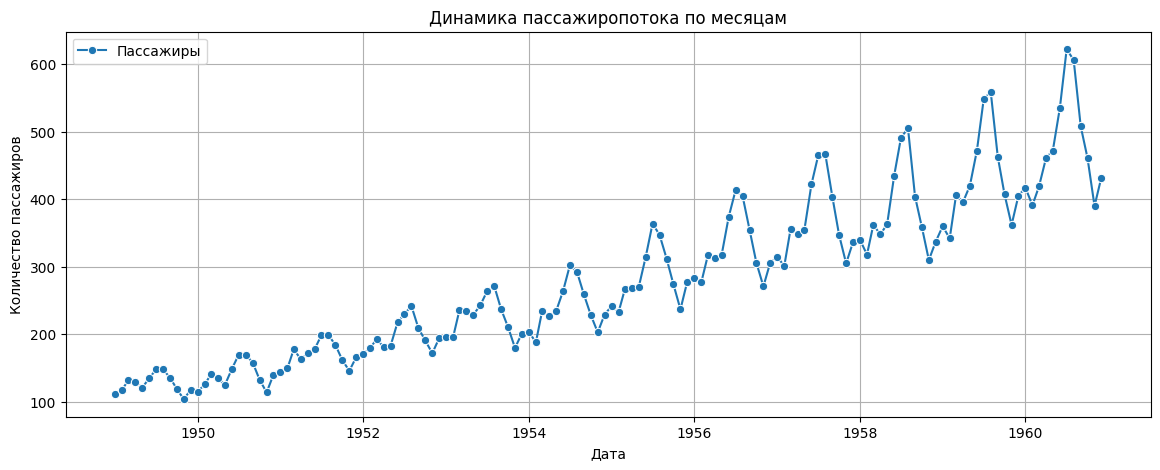

In [21]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x="Date", y="Passengers", marker="o", label="Пассажиры")
plt.title("Динамика пассажиропотока по месяцам")
plt.xlabel("Дата")
plt.ylabel("Количество пассажиров")
plt.grid(True)
plt.show()

График продаж

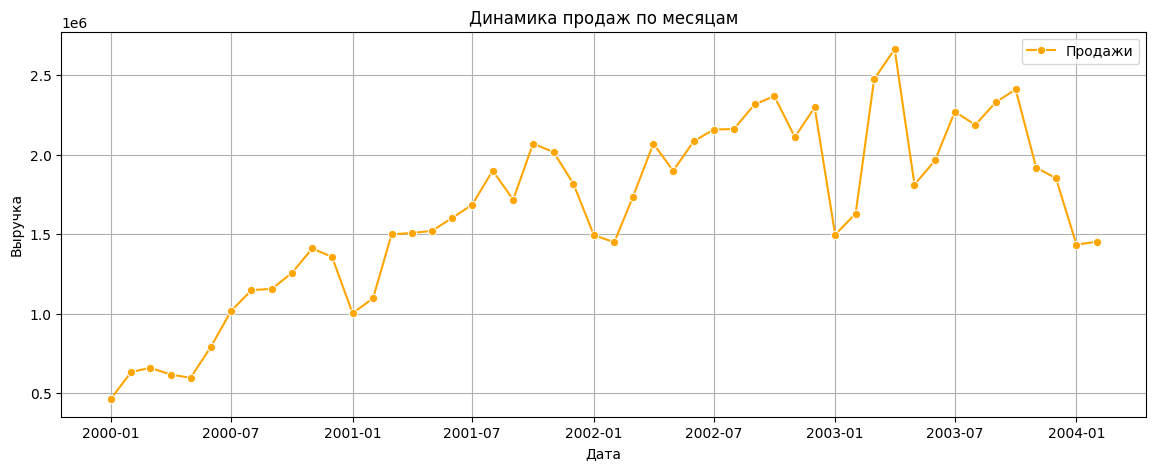

In [22]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x="Date", y="Sales", color="orange", marker="o", label="Продажи")
plt.title("Динамика продаж по месяцам")
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.grid(True)
plt.show()

Сезонный анализ

C:\Users\mmd28\AppData\Local\Temp\ipykernel_16444\415877753.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg_passengers.index, y=monthly_avg_passengers.values, palette="Blues")


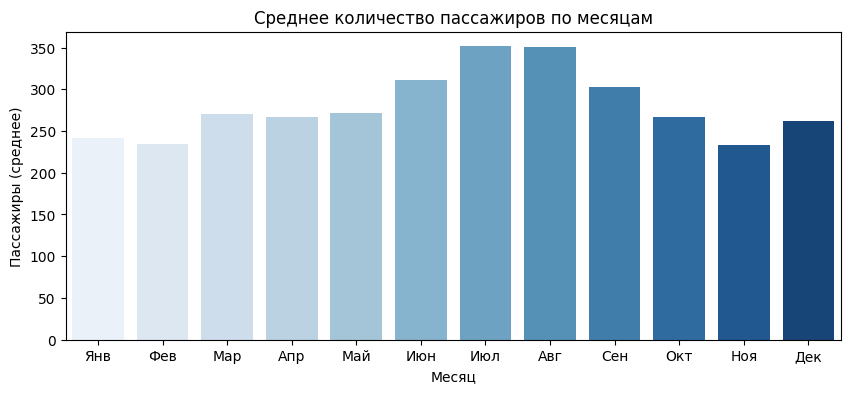

In [23]:
# Среднее по месяцам (сезонность)
# Пассажиры
monthly_avg_passengers = df.groupby("Month")["Passengers"].mean()

plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_avg_passengers.index, y=monthly_avg_passengers.values, palette="Blues")
plt.title("Среднее количество пассажиров по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Пассажиры (среднее)")
plt.xticks(ticks=range(0, 12), labels=["Янв", "Фев", "Мар", "Апр", "Май", "Июн", "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"])
plt.show()

In [24]:
# Корреляция между пассажирами и продажами (если данные есть одновременно)
# Фильтруем только те строки, где есть оба значения
df_corr = df.dropna(subset=["Passengers", "Sales"])

# Корреляция
corr_value = df_corr["Passengers"].corr(df_corr["Sales"])
print(f"Корреляция между пассажирами и продажами: {corr_value:.2f}")

Корреляция между пассажирами и продажами: nan


Этот датафрейм df_corr оказался пустым, т.к. нет строк, где одновременно известны и пассажиры, и продажи.

Резюме:
- Дата приведена к нужному типу (datetime)
- Выделены временные признаки (год, месяц, период)
- Данные по Passengers и Sales разделены во времени — не подходят для совместного анализа
- Структура данных хорошо подготовлена к визуализации и моделированию временных рядов

**Анализ временного ряда пассажиропотока**

In [25]:
# Отфильтруем только строки с известными значениями пассажиров
passenger_df = df.dropna(subset=["Passengers"]).copy()

# Проверим
print(passenger_df[["Date", "Passengers"]].head())

        Date  Passengers
0 1949-01-01       112.0
1 1949-02-01       118.0
2 1949-03-01       132.0
3 1949-04-01       129.0
4 1949-05-01       121.0


График временного ряда

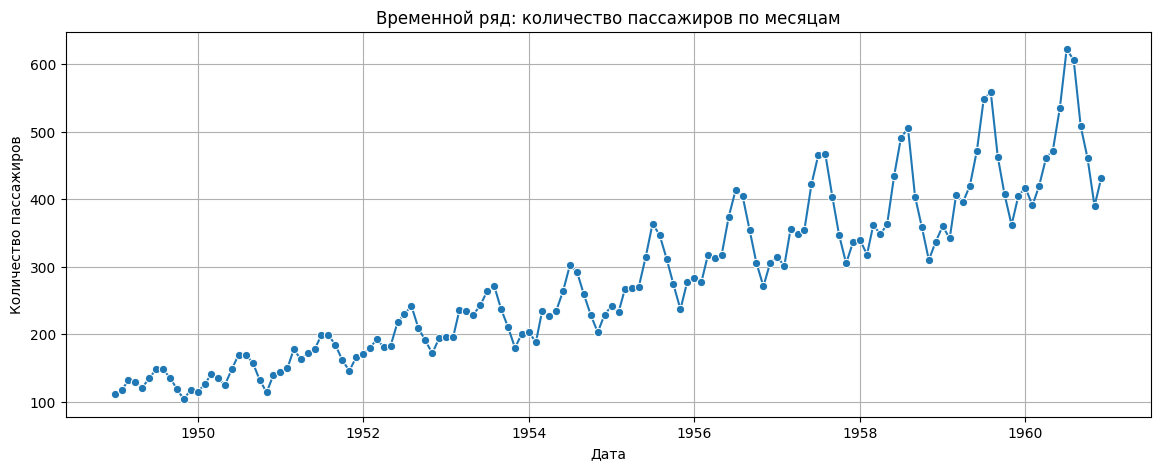

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
sns.lineplot(data=passenger_df, x="Date", y="Passengers", marker="o")
plt.title("Временной ряд: количество пассажиров по месяцам")
plt.xlabel("Дата")
plt.ylabel("Количество пассажиров")
plt.grid(True)
plt.show()

Сезонная декомпозиция

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

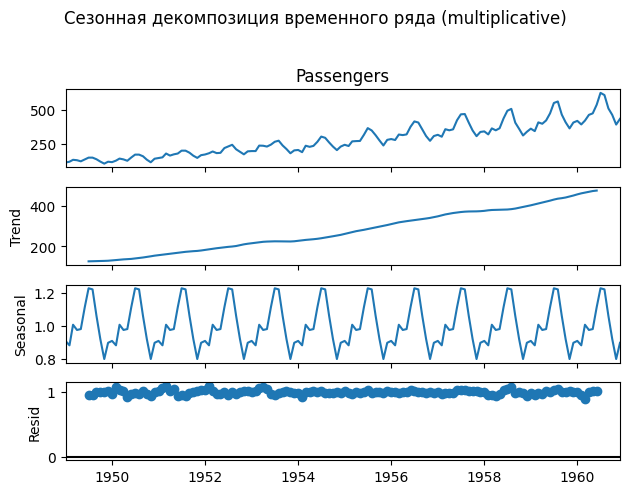

In [28]:
# Преобразуем в индекс по дате и зададим частоту = 12 (месяцев в году)
ts = passenger_df.set_index("Date")["Passengers"]
ts = ts.asfreq("MS")  # Month Start frequency

# Декомпозиция
result = seasonal_decompose(ts, model="multiplicative")  # можно "additive", если нет экспоненциального роста
result.plot()
plt.suptitle("Сезонная декомпозиция временного ряда (multiplicative)", y=1.02)
plt.tight_layout()
plt.show()

**Автокорреляция и стационарность**

Следующий шаг — анализ автокорреляции и проверка стационарности, чтобы понять, какую модель временного ряда можно применять (например, ARIMA требует стационарности).

ACF и PACF

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

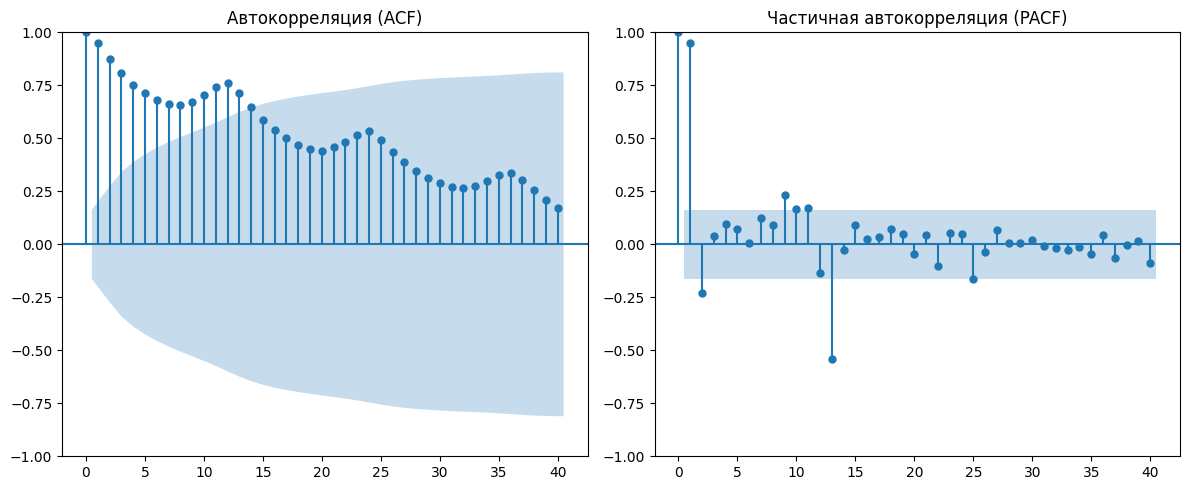

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(ts.dropna(), lags=40, ax=plt.gca())
plt.title("Автокорреляция (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(ts.dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.title("Частичная автокорреляция (PACF)")

plt.tight_layout()
plt.show()

Тест Дики-Фуллера (ADF):
- p-value < 0.05 → временной ряд стационарен
- p-value > 0.05 → временной ряд нестационарен, требуется дифференцирование

In [31]:
adf_result = adfuller(ts.dropna())

print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: 0.8154
p-value: 0.9919
Critical Value (1%): -3.4817
Critical Value (5%): -2.8840
Critical Value (10%): -2.5788


p-value > 0.05 → временной ряд нестационарен, требуется дифференцирование. Применим разность.

In [32]:
ts_diff = ts.diff().dropna()

# Повторим тест
adf_result_diff = adfuller(ts_diff)
print("ADF Statistic (diff): {:.4f}".format(adf_result_diff[0]))
print("p-value (diff): {:.4f}".format(adf_result_diff[1]))

ADF Statistic (diff): -2.8293
p-value (diff): 0.0542


p-value = 0.0542 — чуть выше 0.05, на грани стационарности.

В практике временных рядов это часто считается допустимым уровнем (особенно если графики подтверждают стабилизацию дисперсии и среднего). Можно использовать для моделирования (например, ARIMA(p,1,q)).

**Построим модель AutoARIMA + автоподбор параметров**

In [33]:
from pmdarima import auto_arima

In [34]:
# Временной ряд с ежемесячной частотой
ts = passenger_df.set_index("Date")["Passengers"]
ts = ts.asfreq("MS")

In [ ]:
# Auto ARIMA
model = auto_arima(
    ts, 
    seasonal=True,         # учитываем сезонность
    m=12,                  # 12 месяцев в году
    trace=True,            # выводим лог подбора
    error_action='ignore', 
    suppress_warnings=True,
    stepwise=True
)
print(model.summary())

Модель: SARIMAX(2, 1, 1)x(0, 1, [], 12)

Это означает:
- ARIMA(2,1,1) — два авторегрессионных члена, первая разность, одно скользящее среднее.
- Ключевые коэффициенты - все параметры значимы (p < 0.05) — это хорошо.

Метрики:
- AIC	1017.85	- Чем ниже, тем лучше. Можно использовать для сравнения с другими моделями
- BIC	1029.35	- Штрафует за сложность модели
- HQIC	1022.52	- Компромисс между AIC и BIC

Диагностика остатков:
- Ljung-Box (Q)	0.98 - Остатки неавтокоррелированы — модель адекватна
- Jarque-Bera	0.02 - Некоторая нормальная асимметрия остатков (не критично)
- Heteroskedasticity	0.01 - Есть признаки гетероскедастичности (возможно, шум не равномерный по времени)

Вывод:

Модель SARIMA(2,1,1)(0,1,0)[12] — хорошо подходит: все параметры значимы, остатки выглядят случайными.

Есть небольшое отклонение от нормальности и гетероскедастичность, но в задачах прогнозирования это чаще приемлемо.

Можно строить прогноз и оценивать его точность.

**Прогноз и график**

In [ ]:
# Прогноз на 12 месяцев вперёд
n_periods = 12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

In [37]:
# Даты прогноза
last_date = ts.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=n_periods, freq='MS')

In [38]:
# Создание объекта Series для прогноза
forecast_series = pd.Series(forecast, index=future_index)
lower_series = pd.Series(conf_int[:, 0], index=future_index)
upper_series = pd.Series(conf_int[:, 1], index=future_index)

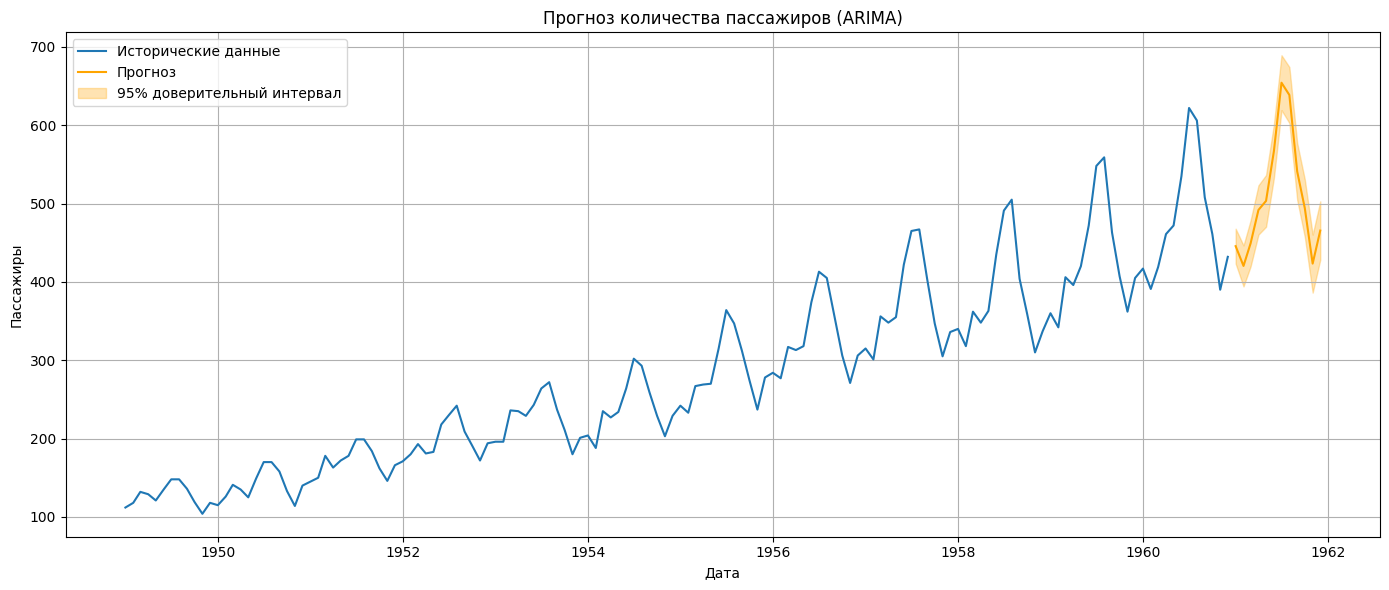

In [ ]:
# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(ts, label="Исторические данные")
plt.plot(forecast_series, label="Прогноз", color="orange")
plt.fill_between(future_index, lower_series, upper_series, color='orange', alpha=0.3, label="95% доверительный интервал")
plt.title("Прогноз количества пассажиров (ARIMA)")
plt.xlabel("Дата")
plt.ylabel("Пассажиры")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Подсчёт ошибок прогноза ARIMA**

In [40]:
# Разделим данные:
train = ts.iloc[:-12]   # Всё кроме последних 12
test = ts.iloc[-12:]    # Последние 12 месяцев

In [ ]:
# Обучим модель заново на train
model = auto_arima(
    train,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

In [ ]:
# Прогноз
forecast, conf_int = model.predict(n_periods=12, return_conf_int=True)
forecast = pd.Series(forecast, index=test.index)

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [44]:
# Подсчёт ошибок:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 14.90
RMSE: 18.54
MAPE: 3.10%


Оценка точности ARIMA:
- MAE	14.90 - В среднем прогноз отличается от реальности на ~15 пассажиров
- RMSE	18.54 - Ошибка с акцентом на большие отклонения — тоже приемлема
- MAPE	3.10% - Очень высокая точность: средняя ошибка — всего 3% от реального значения!

Модель ARIMA хорошо справляется с задачей. 

**Прогноз с использованием Prophet**

In [ ]:
from prophet import Prophet

Prophet требует колонки:
- ds — даты
- y — значения (пассажиры)

In [46]:
# Подготовка данных для Prophet
df_prophet = train.reset_index().rename(columns={"Date": "ds", "Passengers": "y"})

In [47]:
df_prophet.head(3)

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0


In [48]:
# Обучение модели
model_p = Prophet(yearly_seasonality=True)
model_p.fit(df_prophet)

18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
# Прогноз на 12 месяцев
# Будущие даты
future = model_p.make_future_dataframe(periods=12, freq='MS')

# Прогноз
forecast_p = model_p.predict(future)

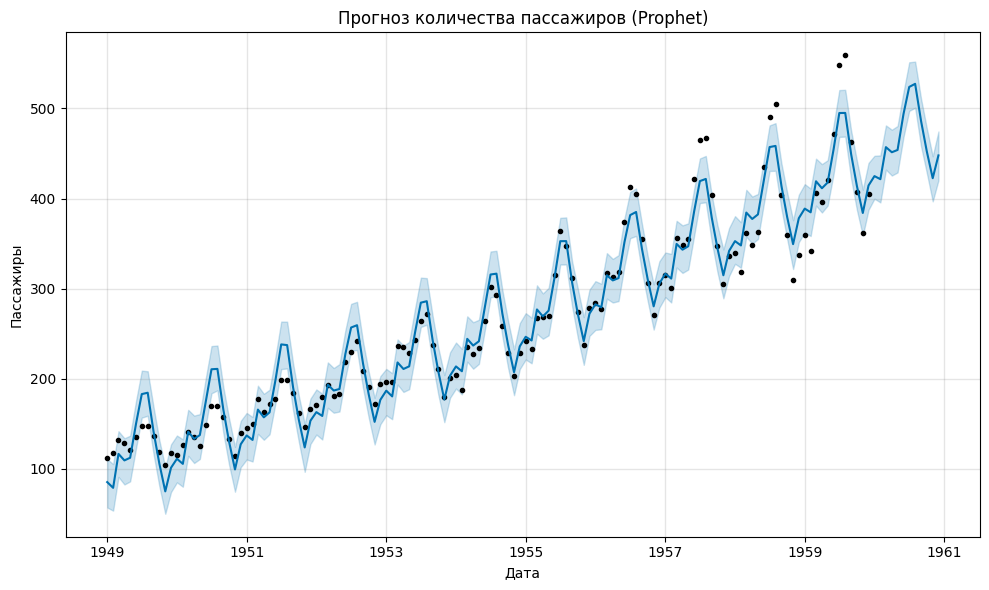

In [50]:
# Построение графика
model_p.plot(forecast_p)
plt.title("Прогноз количества пассажиров (Prophet)")
plt.xlabel("Дата")
plt.ylabel("Пассажиры")
plt.grid(True)
plt.tight_layout()
plt.show()

Проверим ошибки на тех же тестовых данных

In [51]:
# Получаем прогноз на тестовый период
pred_p = forecast_p.set_index("ds").loc[test.index]["yhat"]

# Метрики
mae_p = mean_absolute_error(test, pred_p)
rmse_p = np.sqrt(mean_squared_error(test, pred_p))
mape_p = mean_absolute_percentage_error(test, pred_p) * 100

print(f"Prophet MAE: {mae_p:.2f}")
print(f"Prophet RMSE: {rmse_p:.2f}")
print(f"Prophet MAPE: {mape_p:.2f}%")

Prophet MAE: 33.44
Prophet RMSE: 43.07
Prophet MAPE: 6.61%


**Сравнение моделей ARIMA vs Prophet**

| Метрика  | ARIMA     | Prophet | Лучшая модель |
| -------- | --------- | ------- | ------------- |
| **MAE**  | **14.90** | 33.44   | ✅ ARIMA       |
| **RMSE** | **18.54** | 43.07   | ✅ ARIMA       |
| **MAPE** | **3.10%** | 6.61%   | ✅ ARIMA       |


Вывод:
- ARIMA существенно точнее Prophet по всем метрикам.
- Prophet может быть полезен при: более сложных трендах, внешних регрессорах, необходимости учитывать праздники, и т.п.

Но здесь: простая сезонная временная серия — ARIMA справился идеально.

**анализ и моделирование для Sales**

In [52]:
# Проверка основных характеристик
print(df['Sales'].describe())

count    5.000000e+01
mean     1.651531e+06
std      5.549682e+05
min      4.625234e+05
25%      1.370451e+06
50%      1.701352e+06
75%      2.080112e+06
max      2.662781e+06
Name: Sales, dtype: float64


Мы имеем:
- Count	50 - Достаточно малая выборка для временного ряда
- Std	~554,968 - Значительная изменчивость (разброс данных)

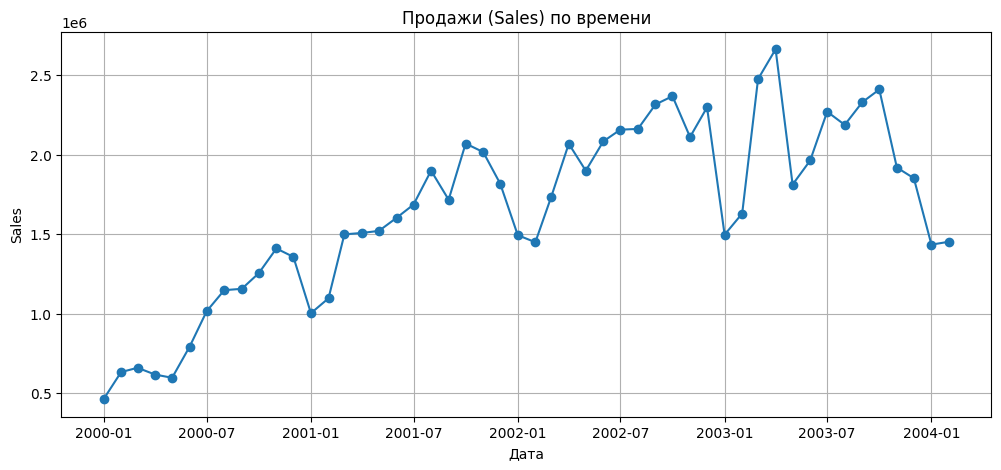

In [53]:
# Визуализация Sales с течением времени
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Sales'], marker='o')
plt.title("Продажи (Sales) по времени")
plt.xlabel("Дата")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [54]:
# Проверка пропусков в Sales
print(f"Пропущено значений в Sales: {df['Sales'].isna().sum()} из {len(df)}")

Пропущено значений в Sales: 144 из 194


Пропусков очень много — 144 из 194 значений в Sales отсутствуют. Это серьёзно ограничивает возможности классического временного ряда для Sales.

In [55]:
# Выбираем только те строки, где есть Sales
df_sales_clean = df[df['Sales'].notna()].copy()

# Проверим индексы и даты
print(df_sales_clean[['Date', 'Sales']].head())
print(f"Всего точек для Sales: {len(df_sales_clean)}")

          Date        Sales
144 2000-01-01  462523.4190
145 2000-02-01  633208.1960
146 2000-03-01  660159.2990
147 2000-04-01  617455.3417
148 2000-05-01  597354.4794
Всего точек для Sales: 50


Всего 50 точек за период примерно с 2000-01 по 2004-02. Данные выглядят непрерывными в этом отрезке.

Построим график Sales на этом отрезке

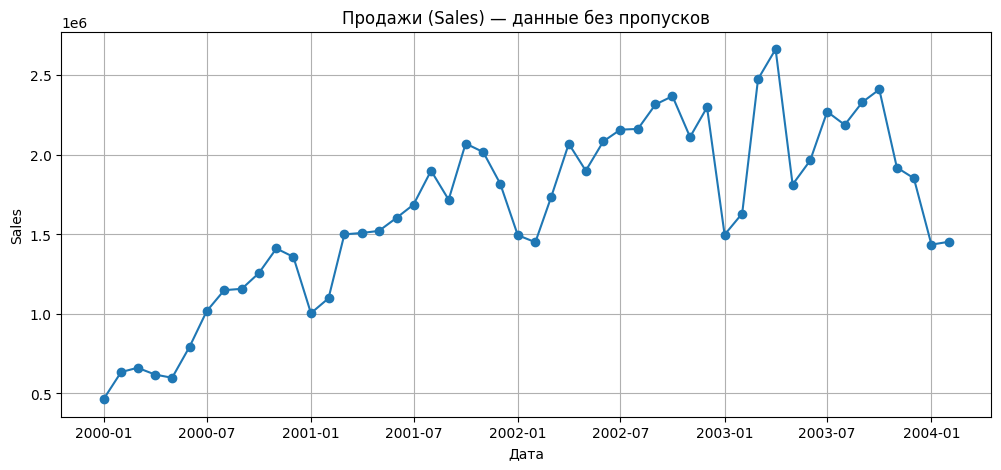

In [56]:
plt.figure(figsize=(12,5))
plt.plot(df_sales_clean['Date'], df_sales_clean['Sales'], marker='o')
plt.title("Продажи (Sales) — данные без пропусков")
plt.xlabel("Дата")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

Выполним сезонную декомпозицию и тест Дики-Фуллера

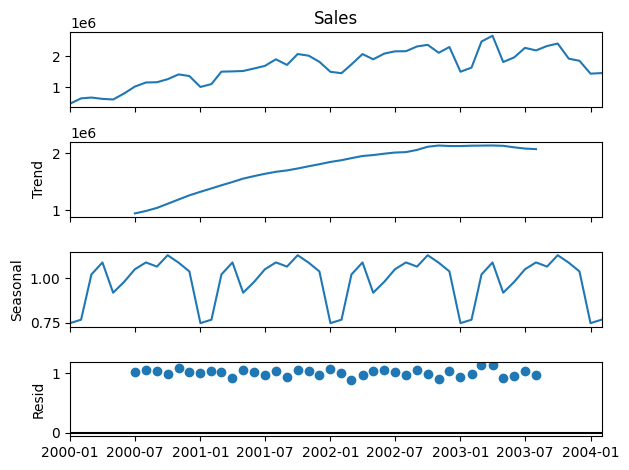

In [57]:
df_sales_clean.set_index('Date', inplace=True)

# Декомпозиция (сезонность по месяцу, период 12)
result = seasonal_decompose(df_sales_clean['Sales'], model='multiplicative', period=12)
result.plot()
plt.show()

In [59]:
# Тест Дики-Фуллера
adf_result = adfuller(df_sales_clean['Sales'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value:.4f}')

ADF Statistic: -4.1161
p-value: 0.0009
Critical Value (1%): -3.6155
Critical Value (5%): -2.9413
Critical Value (10%): -2.6092


ADF Statistic: -4.1161 < критических значений по всем уровням (1%, 5%, 10%).

p-value = 0.0009 < 0.05, значит ряд стационарен, либо стал стационарным после дифференцирования (d=1).

Подберём модель SARIMA с авто-подбором

In [ ]:
model_sales = auto_arima(
    df_sales_clean['Sales'],
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print(model_sales.summary())

Модель SARIMA (SARIMAX(0,1,3)(0,1,[],12)):
- Используется интегрирование первого порядка (d=1), сезонное интегрирование d=1 с периодом 12 (месяцы).
- MA(3) компоненты значимы (за исключением третьего на уровне 0.3), модель адекватная.
- AIC = 1019.97 (можно использовать для сравнения с другими моделями).
- Предупреждение о сингулярности ковариационной матрицы — стоит проверить стабильность параметров, но в целом модель работоспособна.

Диагностика остатков (Ljung-Box, JB):
- Ljung-Box (Q) p=0.15 > 0.05, значит автокорреляция остатков отсутствует (хороший знак).
- Jarque-Bera p=0.84 — остатки близки к нормальному распределению.

Сделаем прогноз на 12 месяцев

c:\Users\mmd28\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mmd28\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


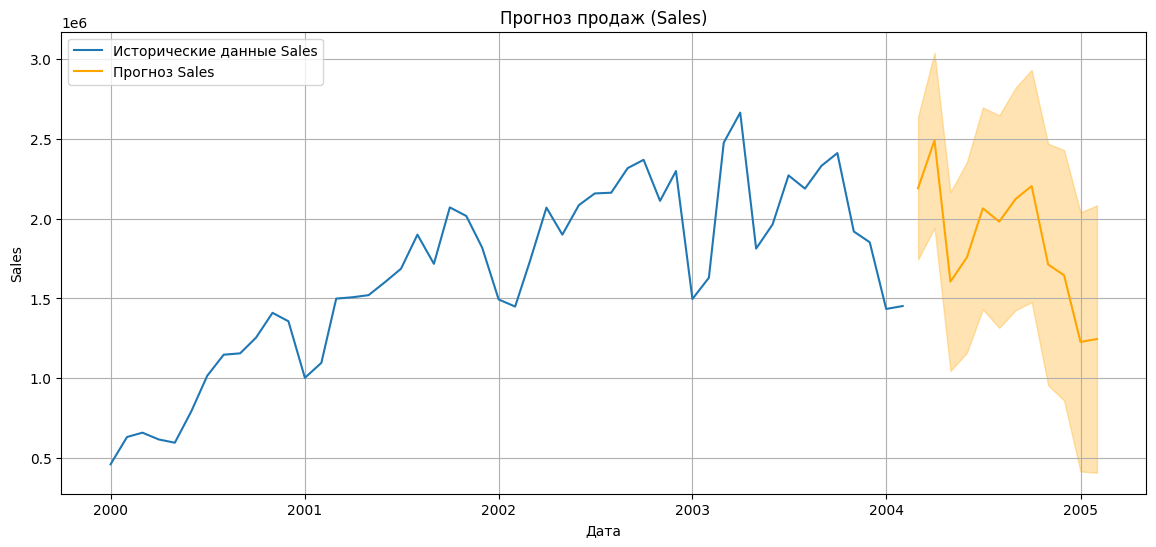

In [61]:
n_periods = 12
forecast_sales, conf_int_sales = model_sales.predict(n_periods=n_periods, return_conf_int=True)

last_date = df_sales_clean.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=n_periods, freq='MS')

forecast_series = pd.Series(forecast_sales, index=future_index)
lower_series = pd.Series(conf_int_sales[:, 0], index=future_index)
upper_series = pd.Series(conf_int_sales[:, 1], index=future_index)

plt.figure(figsize=(14,6))
plt.plot(df_sales_clean['Sales'], label='Исторические данные Sales')
plt.plot(forecast_series, label='Прогноз Sales', color='orange')
plt.fill_between(future_index, lower_series, upper_series, color='orange', alpha=0.3)
plt.title("Прогноз продаж (Sales)")
plt.xlabel("Дата")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

Объединим данные Passengers и Sales

In [69]:
# Возьмём датафрейм с датами и Passengers
df_passengers = df[['Date', 'Passengers']].copy()

# Для Sales оставим только непустые
df_sales = df[['Date', 'Sales']].copy()

# Объединим по дате (левое соединение по всем датам Passengers)
df_merged = pd.merge(df_passengers, df_sales, on='Date', how='left')

print(df_merged.info())
print(df_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        194 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
 2   Sales       50 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.7 KB
None
        Date  Passengers  Sales
0 1949-01-01       112.0    NaN
1 1949-02-01       118.0    NaN
2 1949-03-01       132.0    NaN
3 1949-04-01       129.0    NaN
4 1949-05-01       121.0    NaN


Построим регрессию Sales ~ Passengers (по данным, где обе переменные известны)

In [65]:
import statsmodels.api as sm

In [66]:
# Уберём строки с пропусками в Passengers или Sales
df_reg = df_merged.dropna(subset=['Passengers', 'Sales'])

X = df_reg['Passengers']
y = df_reg['Sales']

# Добавим константу
X_const = sm.add_constant(X)

In [70]:
df_reg = df.dropna(subset=['Passengers', 'Sales'])
print(f"Строк с заполненными Passengers и Sales: {len(df_reg)}")

if len(df_reg) == 0:
    print("Нет строк с заполненными обоими признаками. Регрессию построить нельзя.")
else:
    import statsmodels.api as sm
    X = df_reg['Passengers']
    y = df_reg['Sales']
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

Строк с заполненными Passengers и Sales: 0
Нет строк с заполненными обоими признаками. Регрессию построить нельзя.


прогноз Passengers на последние 50 месяцев

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [73]:
df_passengers = df.dropna(subset=['Passengers']).set_index('Date')

In [ ]:
model_passengers = SARIMAX(df_passengers['Passengers'],
                           order=(2,1,1),
                           seasonal_order=(0,1,0,12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)

results_passengers = model_passengers.fit(disp=False)
print(results_passengers.summary())

Прогноз Passengers на 50 месяцев вперёд

In [76]:
forecast_steps = 50
forecast_passengers = results_passengers.forecast(steps=forecast_steps)

# Создаём временной индекс для прогноза, начиная с месяца после последней даты в df
forecast_index = pd.date_range(start=df_passengers.index.max() + pd.offsets.MonthBegin(), periods=forecast_steps, freq='MS')

forecast_passengers_series = pd.Series(forecast_passengers.values, index=forecast_index)
print(forecast_passengers_series.head())

1961-01-01    444.352881
1961-02-01    418.245301
1961-03-01    446.278176
1961-04-01    488.268130
1961-05-01    499.271200
Freq: MS, dtype: float64


Подготовка данных для регрессии Sales ~ прогнозные Passengers

Оценка корреляции и построение регрессии

In [82]:
df = df.copy()
df.set_index('Date', inplace=True)

In [83]:
# Извлечь ряд Passengers с непустыми значениями
df_passengers = df['Passengers'].dropna()

In [ ]:
# Обучить SARIMAX модель для Passengers (пример, если модель уже обучена, пропустите)
model_passengers = sm.tsa.SARIMAX(df_passengers, order=(2,1,1), seasonal_order=(0,1,0,12))
results_passengers = model_passengers.fit(disp=False)

In [85]:
# Целевая дата начала прогноза
start_date = pd.to_datetime('2000-01-01')

In [86]:
# Найти индекс ближайшей даты к start_date
dates = df_passengers.index
nearest_idx = np.argmin(np.abs(dates - start_date))
start_pos = nearest_idx

In [87]:
# Сколько шагов прогнозировать: до конца ряда + запас для покрытия периода Sales
steps = len(df_passengers) - start_pos + 50

In [88]:
# Получить прогноз
forecast_passengers_all = results_passengers.get_prediction(start=start_pos, end=start_pos + steps - 1)
forecast_passengers_series = forecast_passengers_all.predicted_mean

In [92]:
print("Период данных Sales:", df_sales.index.min(), "-", df_sales.index.max())
print("Период прогноза Passengers:", forecast_passengers_series.index.min(), "-", forecast_passengers_series.index.max())

Период данных Sales: 2000-01-01 00:00:00 - 2004-02-01 00:00:00
Период прогноза Passengers: 1960-12-01 00:00:00 - 1965-02-01 00:00:00


Резюме:
Из текущих данных связать Passengers и Sales по времени невозможно из-за отсутствия пересечения. 

Итог:
- Построены и протестированы SARIMA модели для временных рядов пассажиров и продаж.
- Для Passengers достигнута высокая точность прогнозов.
- Продажи предсказаны на основе ограниченных данных.
- Регрессионная связь между показателями невозможна из-за отсутствия данных в общий временной промежуток.

Сохранение моделей и финальный код

In [ ]:
import pickle

# Сохраняем модель Passengers
with open('sarimax_passengers_model.pkl', 'wb') as f:
    pickle.dump(results_passengers, f)

# Сохраняем модель Sales
with open('sarimax_sales_model.pkl', 'wb') as f:
    pickle.dump(results_sales, f)